In [1]:
import pandas as pd
import numpy as np
from scipy import linalg

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn import feature_selection
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib import colors

In [2]:
flc = '/Users/pinqingkan/Desktop/Codes/Course_ISLR/data/'
fname = flc + 'Smarket.csv'

In [3]:
X = pd.read_csv(fname, index_col=0)

#### 1st section  
recreate results in 4.6.4 using python

In [4]:
# split into training (before 2005) and testing sets
xtrain = X[X.Year < 2005][['Lag1', 'Lag2']]
ytrain = X[X.Year < 2005].Direction.map({'Up': 1, 'Down': 0})
xtest  = X[X.Year >= 2005][['Lag1', 'Lag2']]
ytest  = X[X.Year >= 2005].Direction.map({'Up': 1, 'Down': 0})
_, Nx = xtrain.shape

In [5]:
# QDA
model = QDA(store_covariance = True).fit(xtrain, ytrain)

QDA shows no obvious difference regarding training data, but visible improvement on testing data accuracy

In [6]:
# prior probability
cnt = 0
for iclass in model.classes_:
    print(iclass, ':\t', model.priors_[cnt])
    cnt += 1

0 :	 0.49198396793587174
1 :	 0.5080160320641283


In [7]:
# class mean of predictors
cnt = 0
print('\t Lag1 \t\t\t Lag2')
for iclass in model.classes_:
    print(iclass, ':\t', model.means_[cnt, 0], '\t', model.means_[cnt, 1])
    cnt += 1

	 Lag1 			 Lag2
0 :	 0.04279022403258651 	 0.0338940936863544
1 :	 -0.03954635108481257 	 -0.031325443786982286


In [8]:
# confusion matrix for test data in year 2005
inds = X[X.Year == 2005].index
ytest2 = model.predict(xtest.loc[inds, :])
metricC = confusion_matrix(ytest, ytest2)
print('true negatives: ', metricC[0, 0], '\t false negatives: ', metricC[1, 0])
print('false positives: ', metricC[0, 1], '\t true positives: ', metricC[1, 1])

true negatives:  30 	 false negatives:  20
false positives:  81 	 true positives:  121


In [9]:
# for test data in year 2005
print('% of correctly predicted: ', sum(ytest == ytest2) / len(inds))

% of correctly predicted:  0.5992063492063492


#### 2nd section  
visualization using [the method in scikit-learn](https://scikit-learn.org/0.16/auto_examples/classification/plot_lda_qda.html)

In [10]:
# prediction
ytrain2 = model.predict(xtrain)

In [11]:
tp = (ytrain == ytrain2)
tp0, tp1 = tp[ytrain == 0], tp[ytrain == 1] # T / F for true negative & true positive
xtrain0, xtrain1 = xtrain[ytrain == 0], xtrain[ytrain == 1]
xtrain0_tp, xtrain0_fp = xtrain0[tp0], xtrain0[~tp0] # ytrain = ytrain2 = 0; ytrain = 0, ytrain2 = 1
xtrain1_tp, xtrain1_fp = xtrain1[tp1], xtrain1[~tp1] # ytrain = ytrain2 = 1; ytrain = 1, ytrain2 = 0

In [12]:
plt.style.use('seaborn-pastel')

In [13]:
def plot_ellipse(splot, mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpatches.Ellipse(mean, 2 * v[0] ** 0.5, 2 * v[1] ** 0.5,
                              180 + angle, facecolor=color,
                              edgecolor='yellow',
                              linewidth=2, zorder=2)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)
    splot.add_artist(ell)
    splot.set_xticks(())
    splot.set_yticks(())

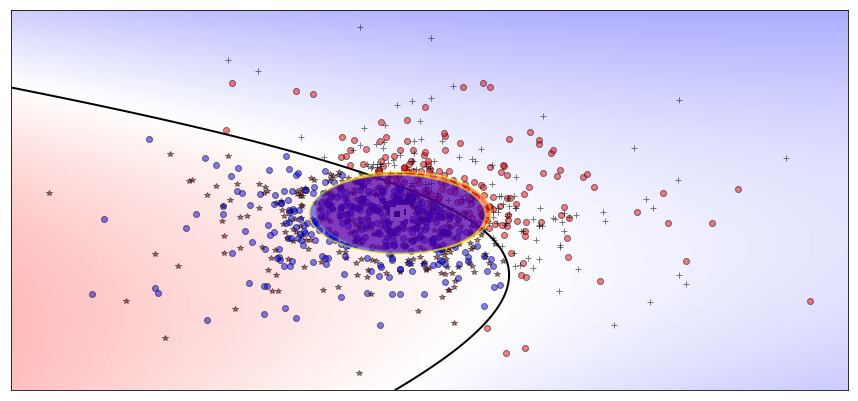

In [14]:
fig, ax1 = plt.subplots(1, 1, figsize = (15, 7))

# class 0: dots
alpha = 0.5
plt.plot(xtrain0_tp.iloc[:, 0], xtrain0_tp.iloc[:, 1], 'o', alpha=alpha,
         color='red', markeredgecolor='k')
plt.plot(xtrain0_fp.iloc[:, 0], xtrain0_fp.iloc[:, 1], '*', alpha=alpha,
         color='#990000', markeredgecolor='k')  # dark red
# class 1: dots
plt.plot(xtrain1_tp.iloc[:, 0], xtrain1_tp.iloc[:, 1], 'o', alpha=alpha,
         color='blue', markeredgecolor='k')
plt.plot(xtrain1_fp.iloc[:, 0], xtrain1_fp.iloc[:, 1], '+', alpha=alpha,
         color='#000099', markeredgecolor='k')  # dark blue

# class 0 and 1 : areas
nx, ny = 200, 100
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                     np.linspace(y_min, y_max, ny))
Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:, 1].reshape(xx.shape) # probability of 1
plt.pcolormesh(xx, yy, Z, cmap='bwr',
                norm=colors.Normalize(0., 1.))
plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='k') # line of probability = 0.5

# covariance
plot_ellipse(ax1, model.means_[0], model.covariance_[0], 'red')
plot_ellipse(ax1, model.means_[1], model.covariance_[1], 'blue')

# class mean
plt.plot(model.means_[0][0], model.means_[0][1],
         's', color='black', markersize=10, markeredgecolor='w', markeredgewidth = 4)
plt.plot(model.means_[1][0], model.means_[1][1],
         's', color='black', markersize=10, markeredgecolor='w', markeredgewidth = 4)